In [1]:
import pandas as pd

cancer_x_resampled_df = pd.read_csv('cancer_x_resampled.csv')
cancer_y_resampled_df = pd.read_csv('cancer_y_resampled.csv')
cancer_x_test_df = pd.read_csv('cancer_x_test.csv')
cancer_y_test_df = pd.read_csv('cancer_y_test.csv')
cancer_x_resampled = cancer_x_resampled_df.values
cancer_y_resampled = cancer_y_resampled_df.values
cancer_x_test = cancer_x_test_df.values
cancer_y_test = cancer_y_test_df.values


Early stopping
Early stopping triggered
              precision    recall  f1-score   support

  not cancer       0.90      0.94      0.92       992
 have cancer       0.26      0.16      0.20       126

    accuracy                           0.86      1118
   macro avg       0.58      0.55      0.56      1118
weighted avg       0.83      0.86      0.84      1118



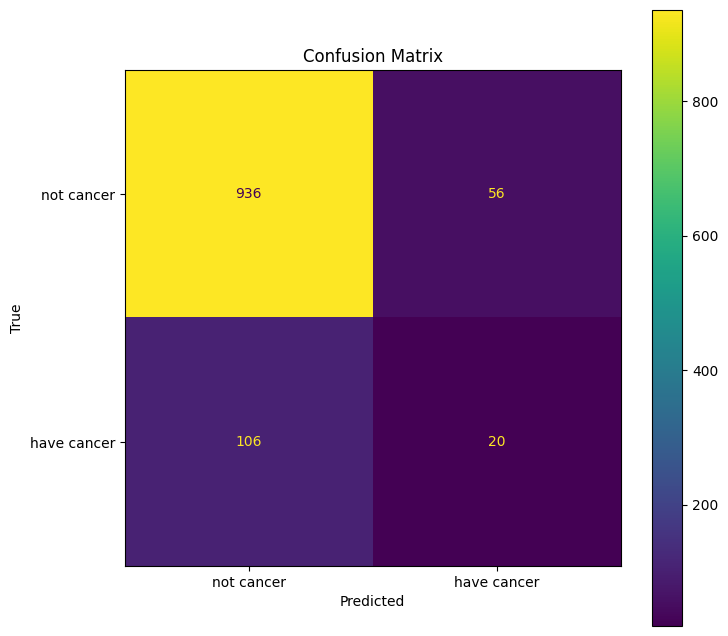

In [133]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

X_train_tensor = torch.tensor(cancer_x_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(cancer_y_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(cancer_x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(cancer_y_test, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

def accuracy(y_hat, y):
    y_pred = (y_hat >= 0.7).float()
    return (y_pred == y).sum().item() / len(y)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")

    def should_stop(self):
        return self.early_stop

input_size = X_train_tensor.shape[1]
hidden_size1 = 32
hidden_size2 = 16
dropout_prob = 0.3
output_size = 1
learning_rate = 0.001
n_epochs = 100
val_per_epoch = 1

model = MLP(input_size, hidden_size1, hidden_size2, output_size, dropout_prob)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
early_stopping = EarlyStopping(patience=20, verbose=True)

history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['val_acc']= list()

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    # print(f"Epoch {epoch+1}/{n_epochs}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.2f}%")

    if epoch % val_per_epoch == val_per_epoch - 1:
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        # print(f"Epoch {epoch+1}/{n_epochs}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc*100:.2f}%")

        early_stopping(val_loss)
        if early_stopping.should_stop():
            print("Early stopping triggered")
            break

    scheduler.step()

model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pred_list.append(outputs)
        y_true_list.append(labels)

y_pred = torch.cat(y_pred_list).cpu().numpy()
y_true = torch.cat(y_true_list).cpu().numpy()
y_pred_bin = (y_pred >= 0.5).astype(int)

report = classification_report(y_true, y_pred_bin, target_names=['not cancer', 'have cancer'])
print(report)

conf_matrix = confusion_matrix(y_true, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['not cancer', 'have cancer'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

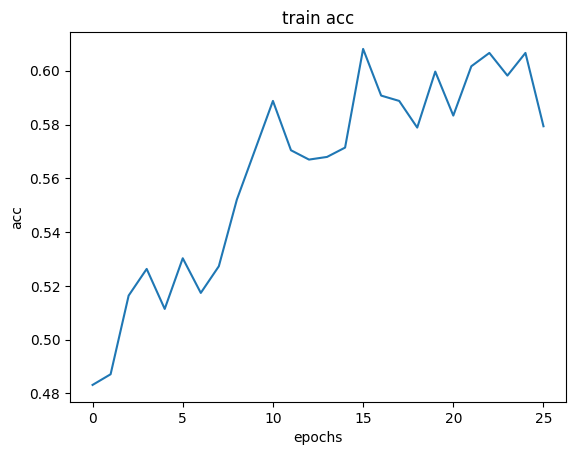

In [130]:
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

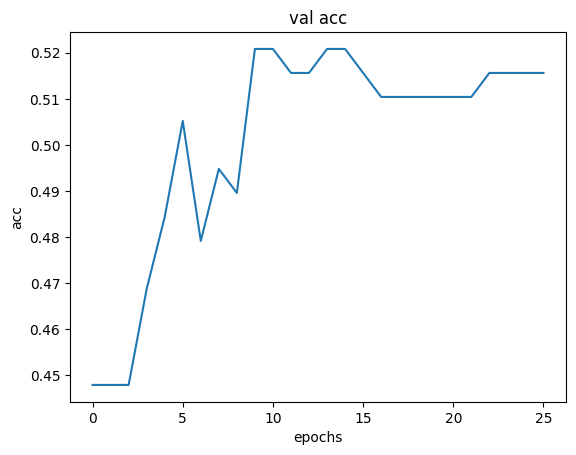

In [131]:
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()